In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from torch.nn import Linear,ReLU
import torch.optim as optim
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter('ignore')

# cuda 

In [2]:
torch.cuda.is_available()

True

In [3]:
def mape(a, b):
    a = np.array(a)
    b = np.array(b)
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

In [4]:
df = pd.read_csv('./data/train.csv',index_col=0)
df.columns = [ i.replace(" ","") for i in df.columns]
df.head()

,CaseConditions_FeedRatetoC013(Input),CaseConditions_C7+inLightEnd(Input),CaseConditions_HeartCutProd.Rate(Input),CaseConditions_C6P-inHeartCut(Input),CaseConditions_FeedRatetoC013(Results),CaseConditions_C7+inLightEnd(Results),CaseConditions_HeartCutProd.Rate(Results),CaseConditions_C6P-inHeartCut(Results),CaseConditions_C10+inHeartCut(Results),NaphthaProperties_NaphthaFeedRate,...,HeavyEndProductProperties_3-Methylnonane,HeavyEndProductProperties_tert-Butylcyclohexane,HeavyEndProductProperties_n-Decane,"HeavyEndProductProperties_1,2-Diethylbenzene",HeavyEndProductProperties_n-Undecane,HeavyEndProductProperties_n-Pentylbenzene,HeavyEndProductProperties_n-Dodecane,HeavyEndProductProperties_n-Hexylbenzene,HeavyEndProductProperties_n-Tridecane,HeavyEndProductProperties_Overall
0,10.0,2.5,100.0,1.0,10.000001,2.500057,100.000198,1.000427,6.138641,118.000084,...,13.956123,2.497176,5.281883,3.507996,1.090498,0.220558,0.020529,0.041371,0.0,99.999993
1,10.0,5.0,100.0,1.0,10.000001,4.999882,100.000122,1.000401,6.249050,118.000000,...,14.167476,2.535975,5.369976,3.569902,1.111782,0.224973,0.020956,0.042241,0.0,100.000002
2,10.0,10.0,100.0,1.0,10.000001,10.000006,100.000008,0.999993,6.376052,118.000000,...,14.722088,2.637226,5.594396,3.724859,1.163364,0.235584,0.021969,0.044298,0.0,99.999983
3,10.0,2.5,100.0,1.5,10.000001,2.500020,100.000275,1.500293,6.316332,118.000000,...,12.408690,2.216235,4.679968,3.101526,0.961640,0.194369,0.018078,0.036421,0.0,100.000004
4,10.0,5.0,100.0,1.5,10.000001,5.000001,99.999817,1.499961,6.416863,118.000084,...,12.534007,2.239314,4.732872,3.139065,0.974726,0.197096,0.018343,0.036962,0.0,99.999999


In [5]:
all_col = df.columns.tolist()

In [6]:
Light = df.columns[df.columns.str.contains('LightEndProductProperties')].tolist()
Heart = df.columns[df.columns.str.contains('HeartCutProductProperties')].tolist()
Heavy = df.columns[df.columns.str.contains('HeavyEndProductProperties')].tolist()
y_col = Light+Heart+Heavy
print(len(y_col))

175


In [7]:
x_col = list(set(all_col)-set(y_col))
print(len(x_col))

99


# scale

In [8]:
mm = MinMaxScaler().fit(df[x_col])
df[x_col] = mm.transform(df[x_col]) 
df[x_col].head()

,"NaphthaProperties_2,3-Dimethyl-1-hexene",NaphthaProperties_4-Methyl-1-hexene,NaphthaProperties_H2O,ColumnTempProfile_C013OvhdTemp,CaseConditions_FeedRatetoC013(Input),NaphthaProperties_Benzene,OperatingPressure_C011Btm,NaphthaProperties_Toluene,NaphthaProperties_EthylBenzene,OperatingPressure_C013Btm,...,Duty_E0623.5KSteamRate,"NaphthaProperties_2,4-Dimethyloctane",CaseConditions_HeartCutProd.Rate(Results),NaphthaProperties_Overall,CaseConditions_C6P-inHeartCut(Results),NaphthaProperties_3-Methylnonane,"NaphthaProperties_2,2-Dimethylpentane",YieldSummary_HeavyEndProd.Rate,ColumnTempProfile_V012OperatingTemp,NaphthaProperties_tert-Butylcyclohexane
0,0.824383,0.499997,0.0,0.571664,0.0,0.071711,0.065673,0.030247,0.040813,0.098742,...,0.557714,0.792325,0.499983,0.543934,0.473694,0.791494,0.653652,0.751601,0.0,0.233403
1,0.824383,0.499997,0.0,0.581642,0.0,0.071711,0.056909,0.030247,0.040813,0.088786,...,0.557820,0.792325,0.499980,0.543934,0.473680,0.791494,0.653652,0.702184,0.0,0.233403
2,0.824383,0.499997,0.0,0.599621,0.0,0.071711,0.047978,0.030247,0.040813,0.079237,...,0.557791,0.792325,0.499974,0.543934,0.473465,0.791494,0.653652,0.625286,0.0,0.233403
3,0.824383,0.499997,0.0,0.522900,0.0,0.071711,0.044633,0.030247,0.040813,0.073828,...,0.557819,0.792325,0.499987,0.543934,0.736658,0.791494,0.653652,0.830308,0.0,0.233403
4,0.824383,0.499997,0.0,0.532107,0.0,0.071711,0.037792,0.030247,0.040813,0.066138,...,0.557714,0.792325,0.499964,0.543934,0.736484,0.791494,0.653652,0.784813,0.0,0.233403


# dataset split and to tensor

In [9]:
from sklearn.model_selection import train_test_split

X = df[x_col].to_numpy()
y = df[y_col].to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#將數據轉為cuda類型
X_train = torch.tensor(X_train, dtype=torch.float).cuda()
X_test = torch.tensor(X_test, dtype=torch.float).cuda()
Y_train = torch.tensor(Y_train, dtype=torch.float).cuda()
Y_test = torch.tensor(Y_test, dtype=torch.float).cuda()

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

torch.Size([4559, 99])
torch.Size([1140, 99])
torch.Size([4559, 175])
torch.Size([1140, 175])


# net

In [10]:
def build_net(input_shape,output_shape):
    net = torch.nn.Sequential(
        Linear(input_shape,256),ReLU(),#INPUT LAYER
        Linear(256,256),ReLU(),#隱藏層
        Linear(256,256),ReLU(),#隱藏層
        Linear(256,output_shape)#OUTPUT LAYER
    )
    return net

def init_weights(m):
    if type(m) == Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0)

net = build_net(len(x_col),len(y_col))
net.apply(init_weights)

#將模型轉為cuda類型
net = net.cuda()

# DataLoader

In [11]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Loss function and optimizer

In [12]:
loss_function = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.0001)

# Training and evaluation

In [13]:
def train(net,train_iter,loss_function,optimizer,num_epochs=500):
    
    train_history = []
    test_history = []
    
    for epoch in range(num_epochs):
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # finish one epoch
        test_loss = loss_function(net(X_test),Y_test).detach()
        print("epochs {} loss {:.4f} test_loss {:.4f}".format(epoch,loss.item(),test_loss.item()))
        train_history.append(loss.item())
        test_history.append(test_loss.item())
    
    # finish all epoch
    roll_num = 10
    train_loss = pd.Series(np.array(train_history)[5:]).rolling(roll_num).mean()
    test_loss = pd.Series(np.array(test_history)[5:]).rolling(roll_num).mean()
    plt.plot(train_loss,label='train_loss')
    plt.plot(test_loss,label='test_loss')
    plt.show()
    return net

epochs 0 loss 311.1550 test_loss 308.7541
epochs 1 loss 305.9401 test_loss 304.0498
epochs 2 loss 295.0696 test_loss 293.6153
epochs 3 loss 273.9128 test_loss 270.3589
epochs 4 loss 229.8582 test_loss 225.7288
epochs 5 loss 165.2063 test_loss 158.7709
epochs 6 loss 89.4022 test_loss 83.8643
epochs 7 loss 32.3050 test_loss 28.4587
epochs 8 loss 11.0449 test_loss 10.1950
epochs 9 loss 8.0123 test_loss 8.4082
epochs 10 loss 7.2106 test_loss 7.8873
epochs 11 loss 6.6954 test_loss 7.6309
epochs 12 loss 6.5001 test_loss 7.4524
epochs 13 loss 6.3488 test_loss 7.2864
epochs 14 loss 5.5539 test_loss 7.0980
epochs 15 loss 6.1421 test_loss 6.9088
epochs 16 loss 7.0182 test_loss 6.7240
epochs 17 loss 7.2092 test_loss 6.5304
epochs 18 loss 6.1114 test_loss 6.3217
epochs 19 loss 5.9963 test_loss 6.1041
epochs 20 loss 5.8569 test_loss 5.8873
epochs 21 loss 5.3924 test_loss 5.6796
epochs 22 loss 6.0545 test_loss 5.4818
epochs 23 loss 4.5486 test_loss 5.2911
epochs 24 loss 4.6749 test_loss 5.1223
epoch

epochs 206 loss 0.4737 test_loss 0.4723
epochs 207 loss 0.4329 test_loss 0.4704
epochs 208 loss 0.4517 test_loss 0.4684
epochs 209 loss 0.5248 test_loss 0.4650
epochs 210 loss 0.4147 test_loss 0.4603
epochs 211 loss 0.4710 test_loss 0.4581
epochs 212 loss 0.4610 test_loss 0.4548
epochs 213 loss 0.4791 test_loss 0.4521
epochs 214 loss 0.4599 test_loss 0.4501
epochs 215 loss 0.4491 test_loss 0.4465
epochs 216 loss 0.4569 test_loss 0.4445
epochs 217 loss 0.4381 test_loss 0.4424
epochs 218 loss 0.4019 test_loss 0.4388
epochs 219 loss 0.4393 test_loss 0.4362
epochs 220 loss 0.4316 test_loss 0.4339
epochs 221 loss 0.4401 test_loss 0.4308
epochs 222 loss 0.4459 test_loss 0.4301
epochs 223 loss 0.4300 test_loss 0.4272
epochs 224 loss 0.4614 test_loss 0.4248
epochs 225 loss 0.3592 test_loss 0.4227
epochs 226 loss 0.3809 test_loss 0.4192
epochs 227 loss 0.3692 test_loss 0.4160
epochs 228 loss 0.4366 test_loss 0.4133
epochs 229 loss 0.4664 test_loss 0.4117
epochs 230 loss 0.3884 test_loss 0.4094


epochs 410 loss 0.1835 test_loss 0.1766
epochs 411 loss 0.1621 test_loss 0.1760
epochs 412 loss 0.1735 test_loss 0.1763
epochs 413 loss 0.1889 test_loss 0.1746
epochs 414 loss 0.1668 test_loss 0.1738
epochs 415 loss 0.1646 test_loss 0.1731
epochs 416 loss 0.1764 test_loss 0.1726
epochs 417 loss 0.1745 test_loss 0.1717
epochs 418 loss 0.1743 test_loss 0.1712
epochs 419 loss 0.1571 test_loss 0.1709
epochs 420 loss 0.1647 test_loss 0.1703
epochs 421 loss 0.1739 test_loss 0.1697
epochs 422 loss 0.1831 test_loss 0.1689
epochs 423 loss 0.1444 test_loss 0.1678
epochs 424 loss 0.2048 test_loss 0.1680
epochs 425 loss 0.1518 test_loss 0.1677
epochs 426 loss 0.1838 test_loss 0.1666
epochs 427 loss 0.1620 test_loss 0.1661
epochs 428 loss 0.1539 test_loss 0.1661
epochs 429 loss 0.1666 test_loss 0.1646
epochs 430 loss 0.1531 test_loss 0.1637
epochs 431 loss 0.1728 test_loss 0.1635
epochs 432 loss 0.1840 test_loss 0.1631
epochs 433 loss 0.1799 test_loss 0.1630
epochs 434 loss 0.1493 test_loss 0.1617


epochs 614 loss 0.0693 test_loss 0.0863
epochs 615 loss 0.0792 test_loss 0.0860
epochs 616 loss 0.1038 test_loss 0.0853
epochs 617 loss 0.0740 test_loss 0.0853
epochs 618 loss 0.0846 test_loss 0.0849
epochs 619 loss 0.0806 test_loss 0.0851
epochs 620 loss 0.0844 test_loss 0.0854
epochs 621 loss 0.0753 test_loss 0.0841
epochs 622 loss 0.0712 test_loss 0.0839
epochs 623 loss 0.0838 test_loss 0.0838
epochs 624 loss 0.0830 test_loss 0.0833
epochs 625 loss 0.0881 test_loss 0.0833
epochs 626 loss 0.0713 test_loss 0.0834
epochs 627 loss 0.0740 test_loss 0.0825
epochs 628 loss 0.0780 test_loss 0.0826
epochs 629 loss 0.0688 test_loss 0.0824
epochs 630 loss 0.0796 test_loss 0.0821
epochs 631 loss 0.0716 test_loss 0.0833
epochs 632 loss 0.0739 test_loss 0.0822
epochs 633 loss 0.0827 test_loss 0.0817
epochs 634 loss 0.0705 test_loss 0.0816
epochs 635 loss 0.0758 test_loss 0.0813
epochs 636 loss 0.0865 test_loss 0.0815
epochs 637 loss 0.0821 test_loss 0.0809
epochs 638 loss 0.0880 test_loss 0.0808


epochs 818 loss 0.0596 test_loss 0.0563
epochs 819 loss 0.0511 test_loss 0.0557
epochs 820 loss 0.0519 test_loss 0.0555
epochs 821 loss 0.0517 test_loss 0.0561
epochs 822 loss 0.0600 test_loss 0.0560
epochs 823 loss 0.0502 test_loss 0.0556
epochs 824 loss 0.0742 test_loss 0.0556
epochs 825 loss 0.0528 test_loss 0.0554
epochs 826 loss 0.0580 test_loss 0.0548
epochs 827 loss 0.0591 test_loss 0.0550
epochs 828 loss 0.0653 test_loss 0.0548
epochs 829 loss 0.0464 test_loss 0.0548
epochs 830 loss 0.0547 test_loss 0.0549
epochs 831 loss 0.0576 test_loss 0.0547
epochs 832 loss 0.0487 test_loss 0.0547
epochs 833 loss 0.0460 test_loss 0.0548
epochs 834 loss 0.0583 test_loss 0.0544
epochs 835 loss 0.0481 test_loss 0.0546
epochs 836 loss 0.0583 test_loss 0.0545
epochs 837 loss 0.0473 test_loss 0.0546
epochs 838 loss 0.0484 test_loss 0.0542
epochs 839 loss 0.0485 test_loss 0.0542
epochs 840 loss 0.0460 test_loss 0.0537
epochs 841 loss 0.0487 test_loss 0.0544
epochs 842 loss 0.0535 test_loss 0.0538


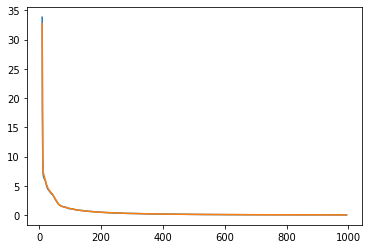

In [14]:
net = train(net,train_iter,loss_function,optimizer,1000)

# metric

In [15]:
y_pred = net(X_test).cpu().detach().numpy()
y_real = Y_test.cpu().numpy()

t = pd.DataFrame(columns=['R2','MSE'])

for idx,c in enumerate(y_col):
    t.loc[c,'R2'] = r2_score(y_real[:,idx],y_pred[:,idx])
    t.loc[c,'MSE'] = mean_squared_error(y_real[:,idx],y_pred[:,idx])
    
t['R2'] = t['R2'].clip(0,1)

In [16]:
t

,R2,MSE
LightEndProductProperties_LightEndProd.Rate,0.997913,0.0612045
LightEndProductProperties_LightEndProd.Rate.1,0.997585,0.0331008
LightEndProductProperties_C7+inLightEnd,0.997932,0.0200522
LightEndProductProperties_Oxygen,0,0.00169765
LightEndProductProperties_Methane,0,0.000874586
...,...,...
HeavyEndProductProperties_n-Pentylbenzene,0.972142,0.00125058
HeavyEndProductProperties_n-Dodecane,0,0.002216
HeavyEndProductProperties_n-Hexylbenzene,0,0.00317444
HeavyEndProductProperties_n-Tridecane,0,0.00107648


In [17]:
t.loc[:,['R2','MSE']].mean(axis=0)

R2     0.458874
MSE    0.042008
dtype: float64

Text(0.5, 1.0, 'MSE')

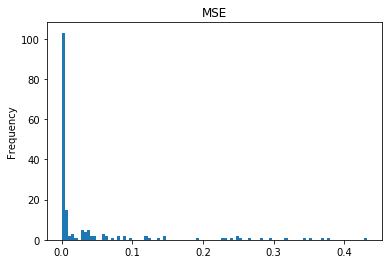

In [18]:
t['MSE'].plot(kind='hist',bins=100)
plt.title('MSE')

# plot error

85


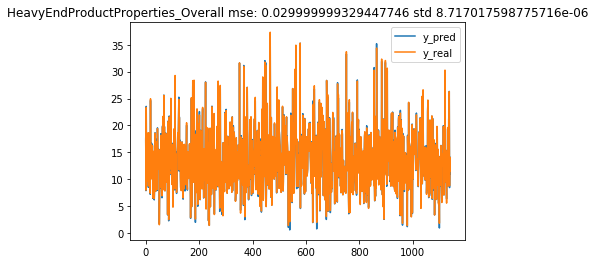

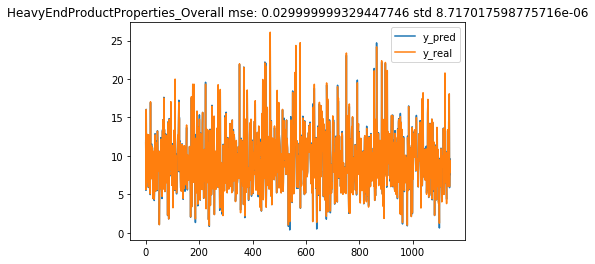

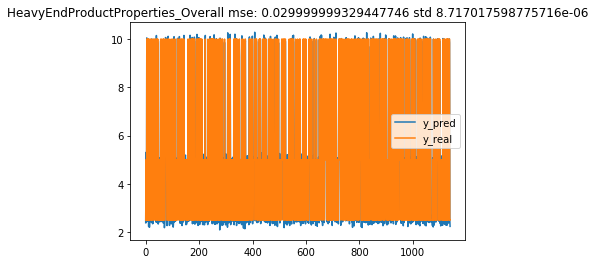

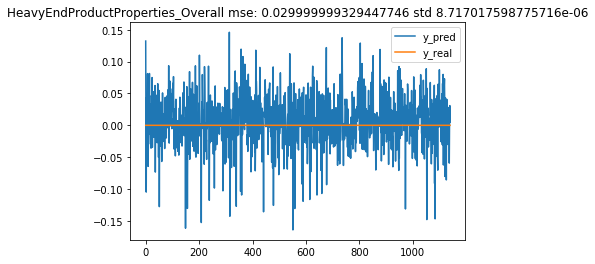

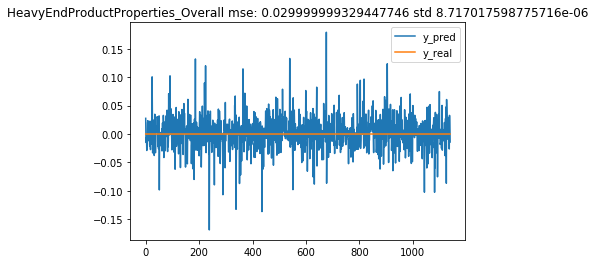

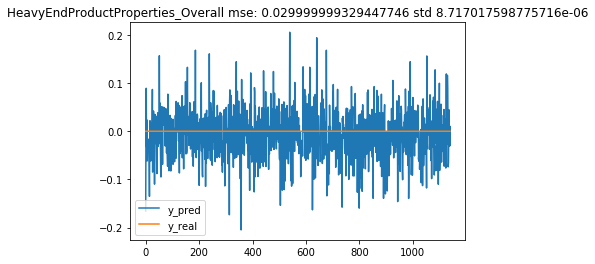

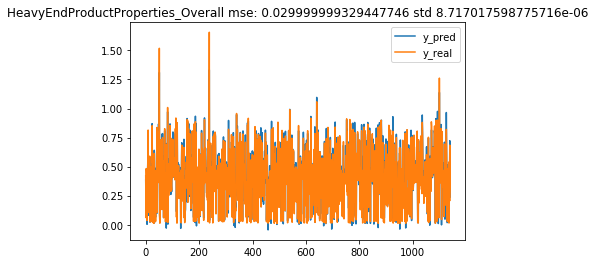

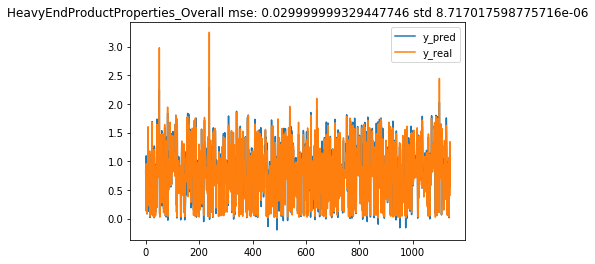

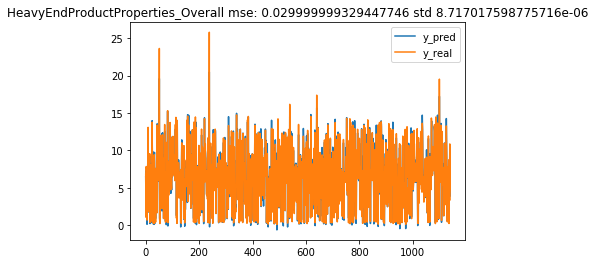

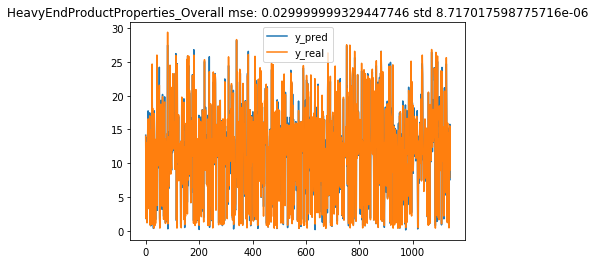

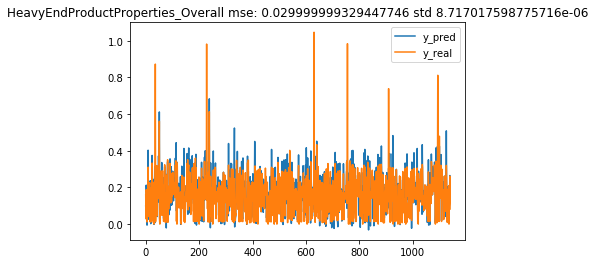

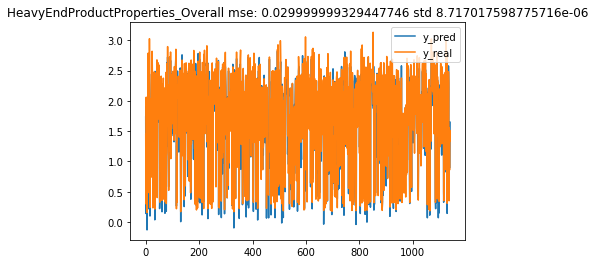

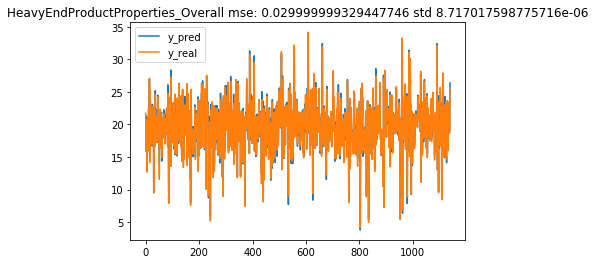

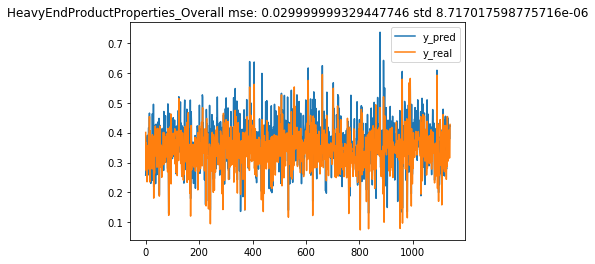

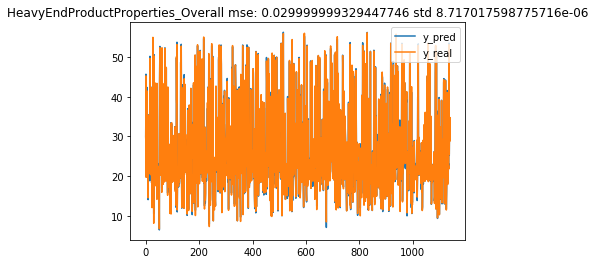

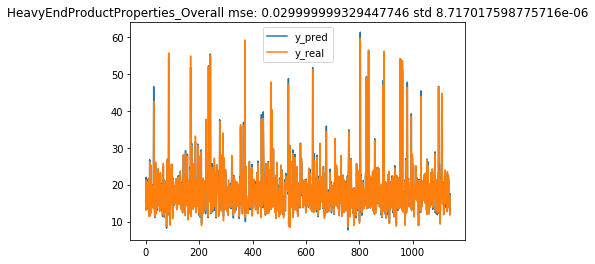

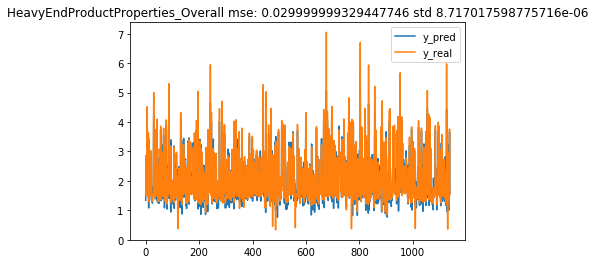

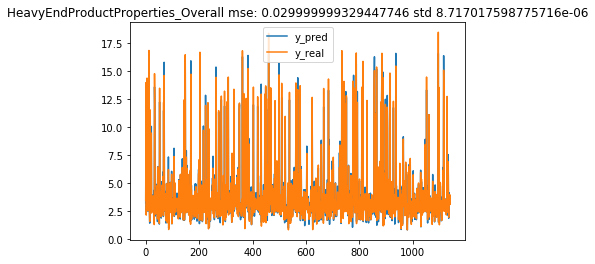

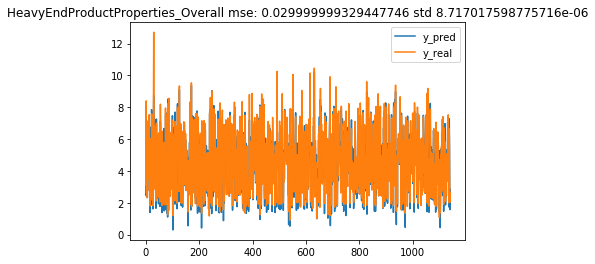

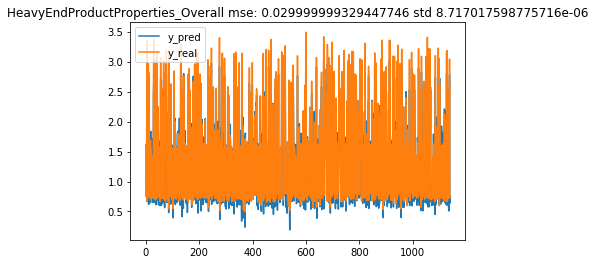

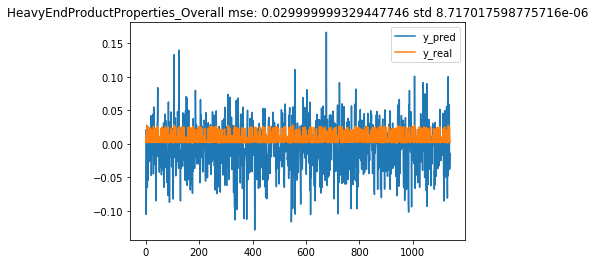

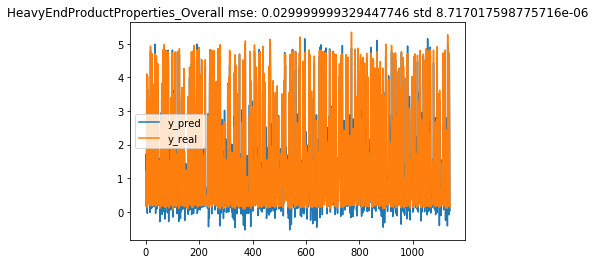

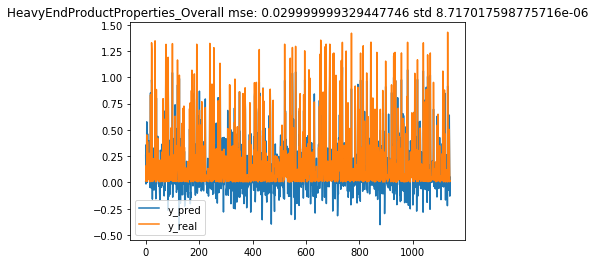

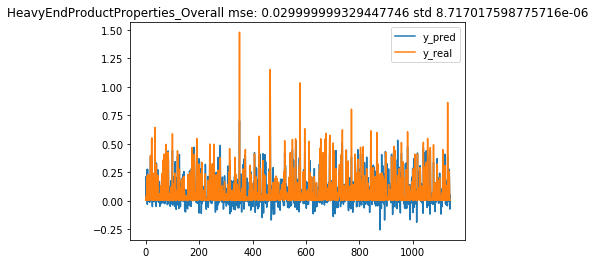

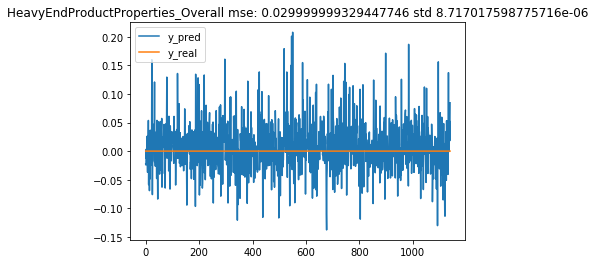

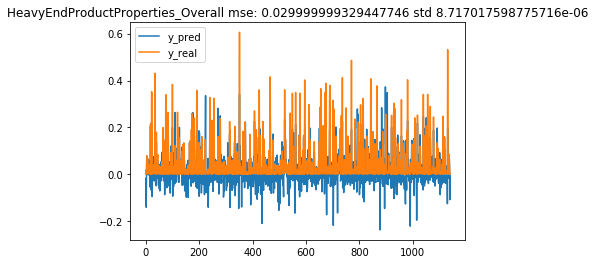

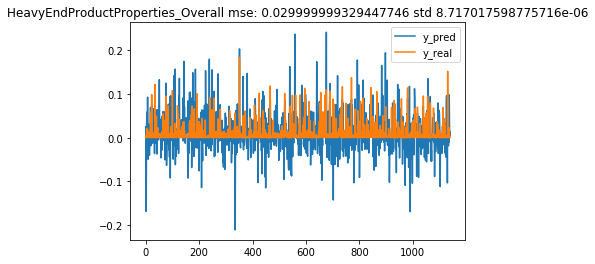

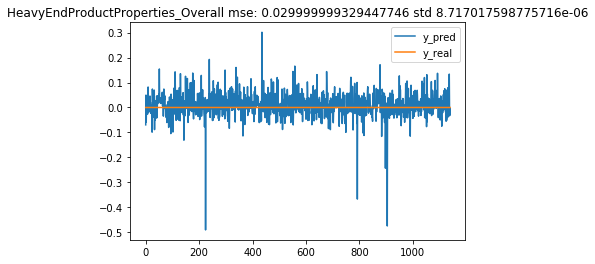

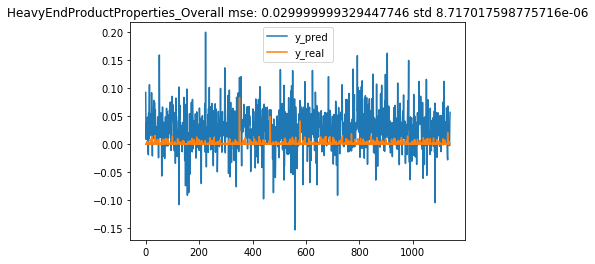

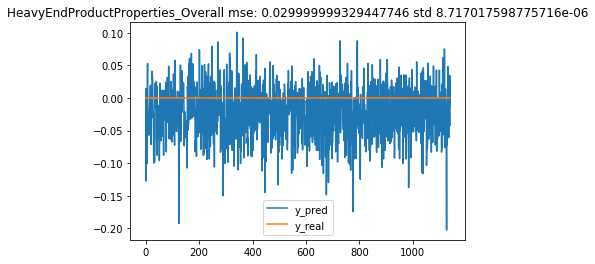

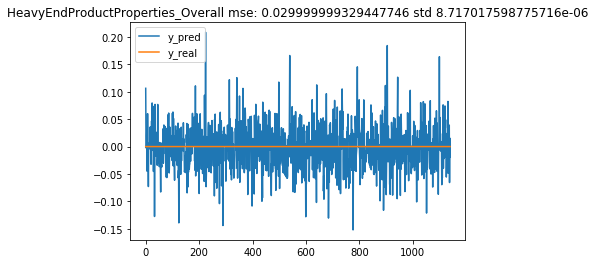

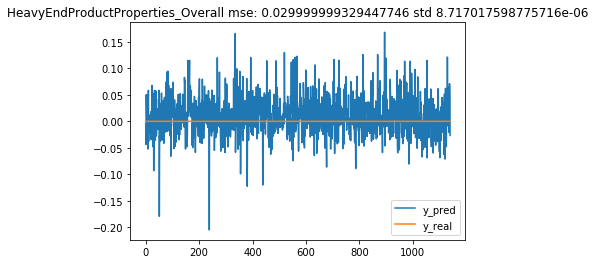

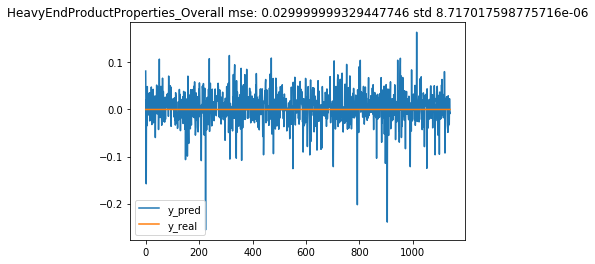

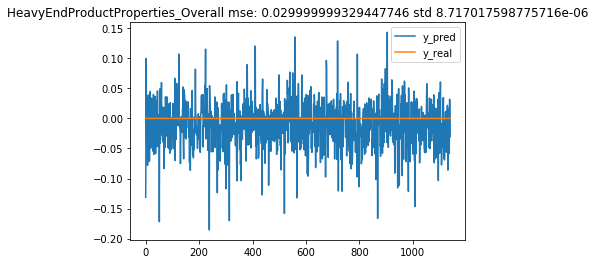

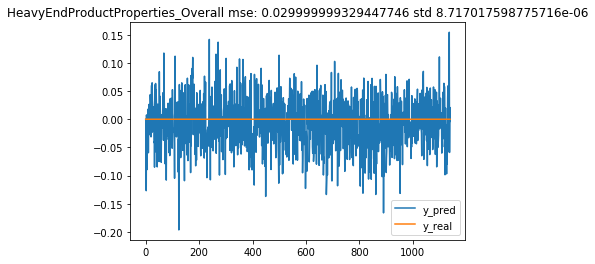

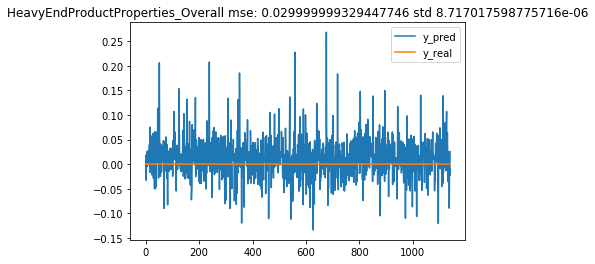

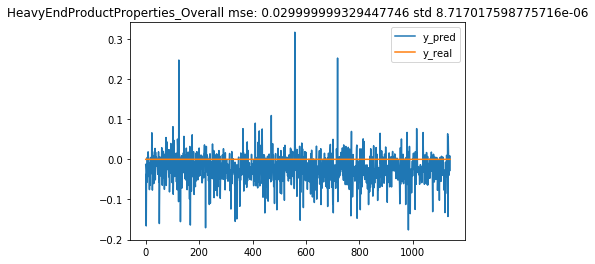

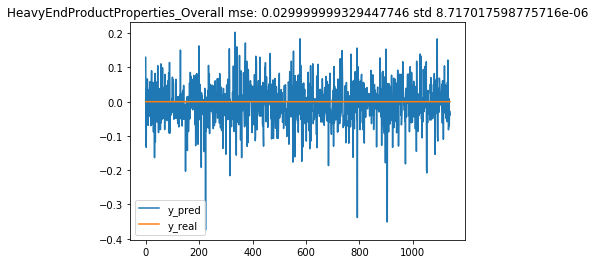

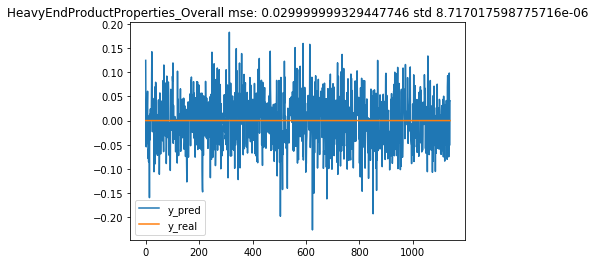

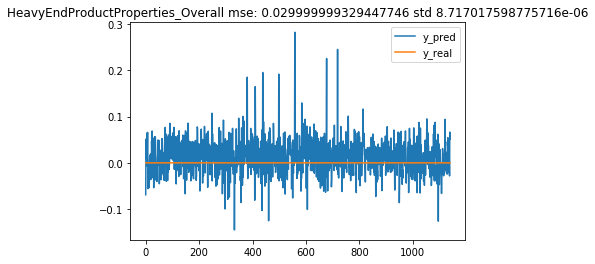

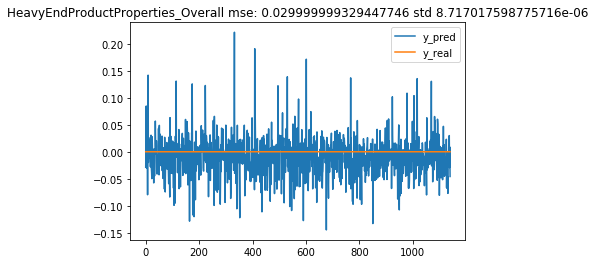

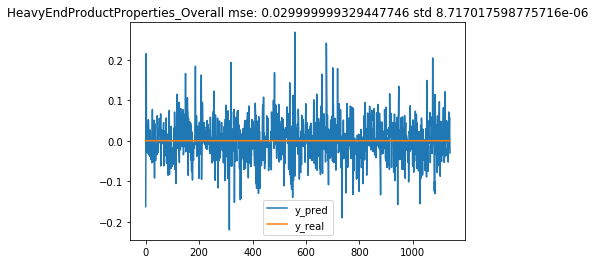

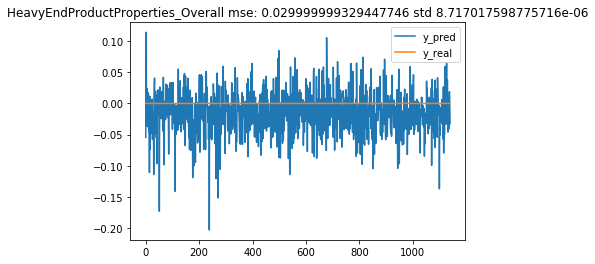

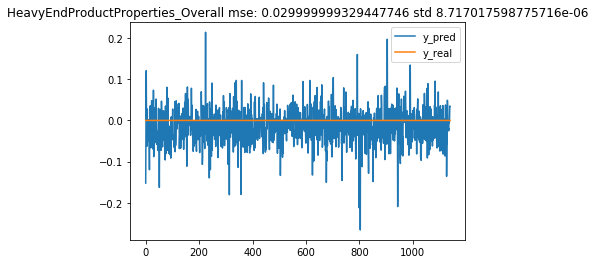

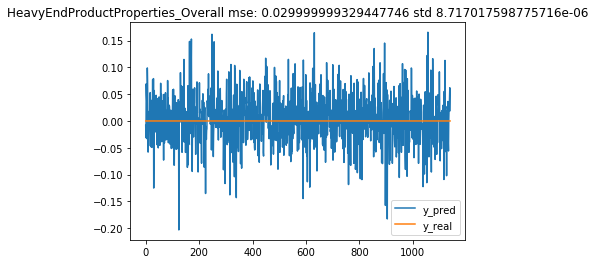

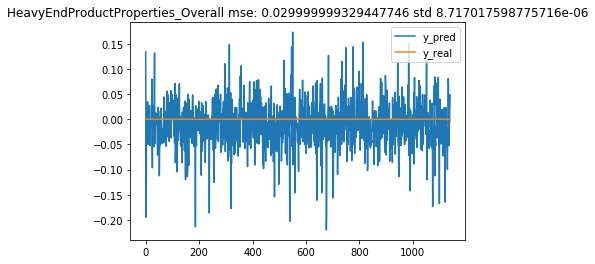

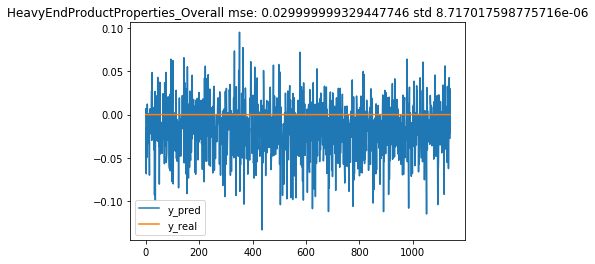

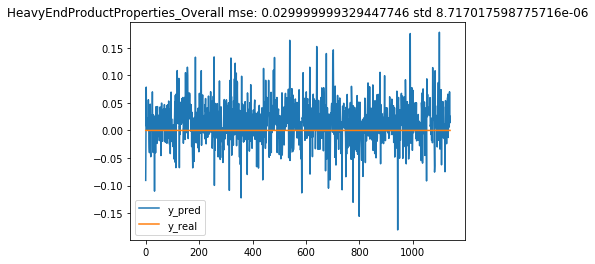

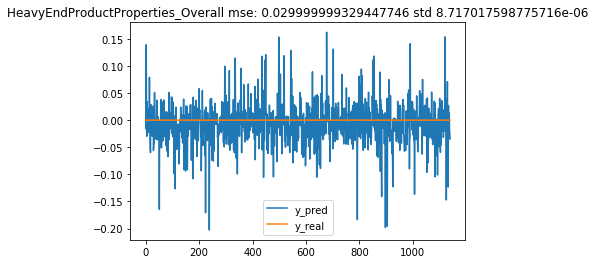

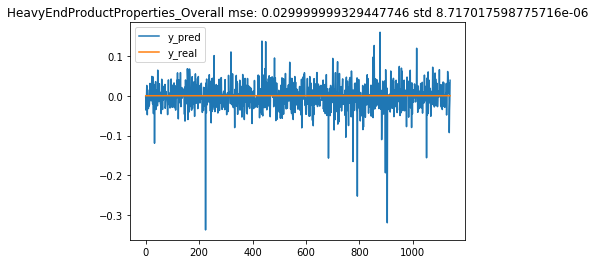

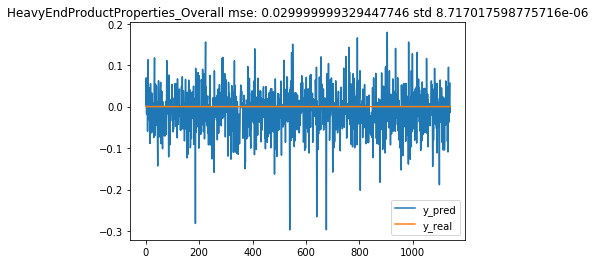

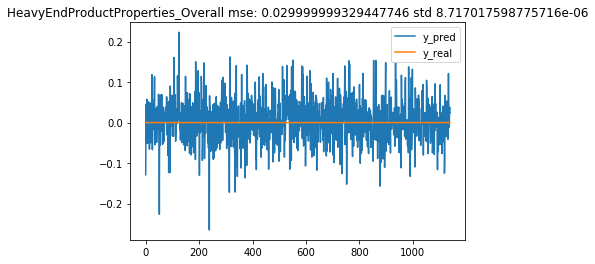

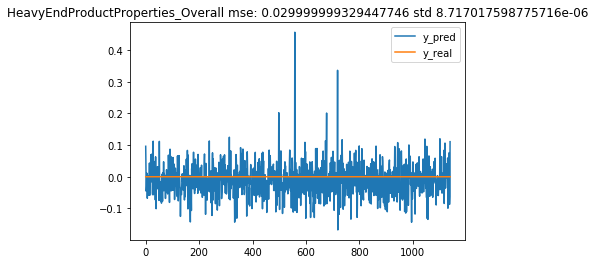

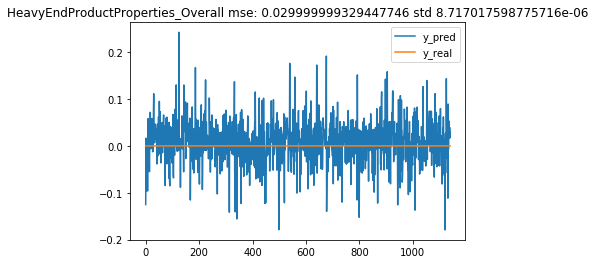

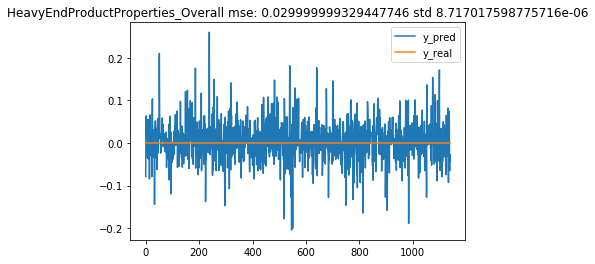

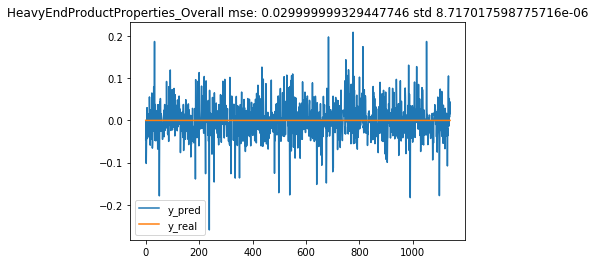

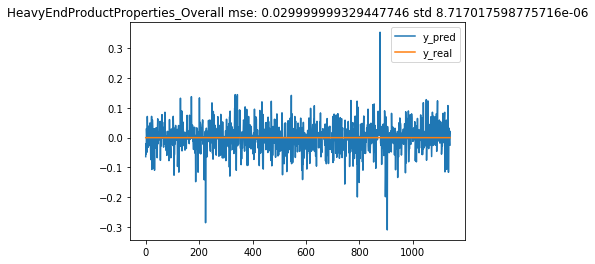

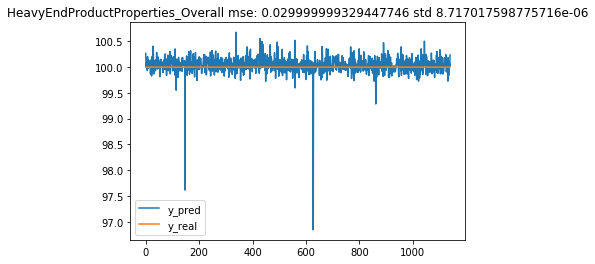

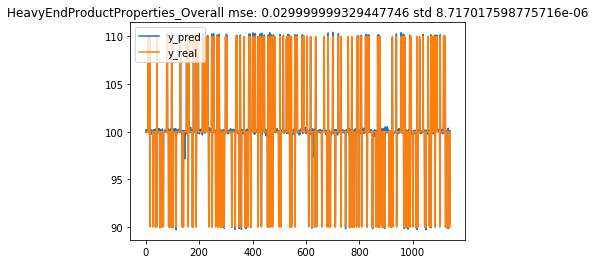

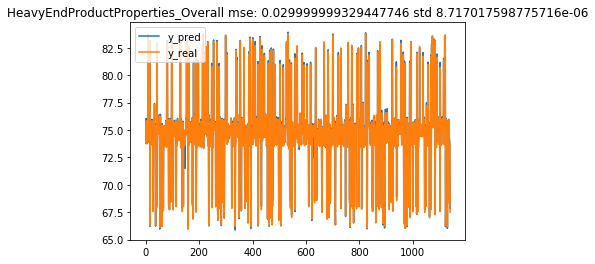

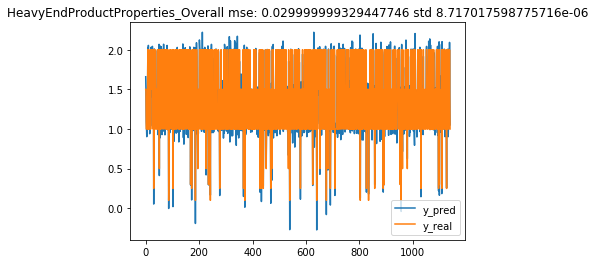

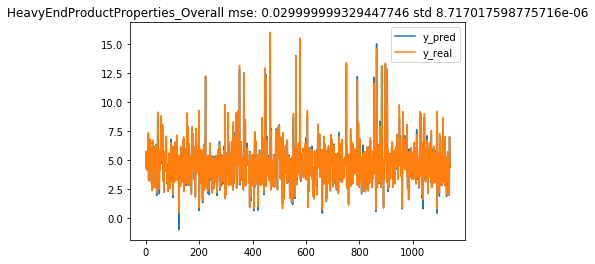

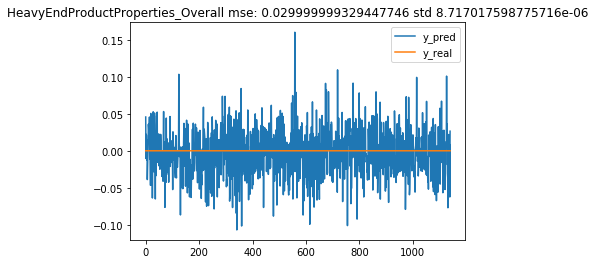

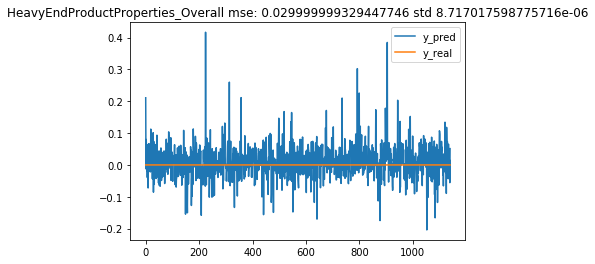

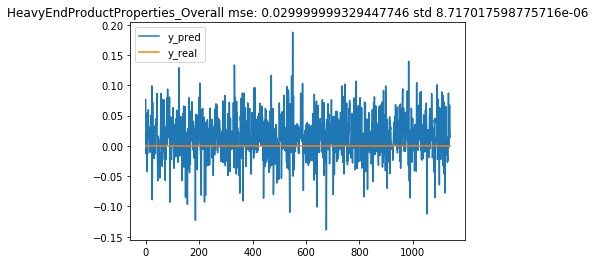

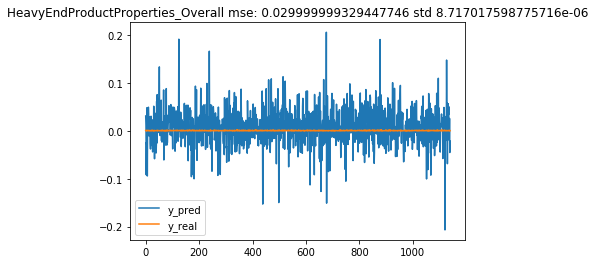

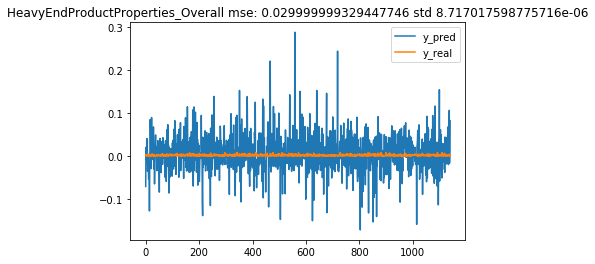

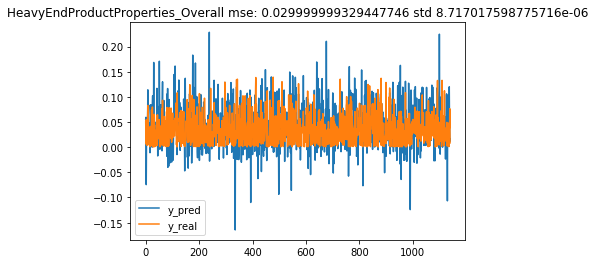

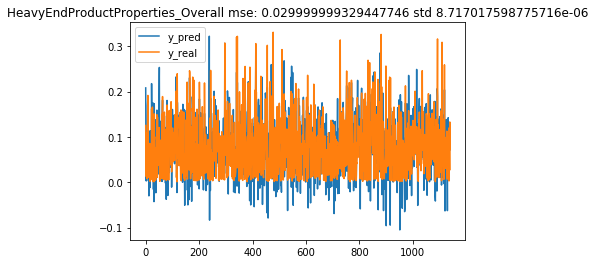

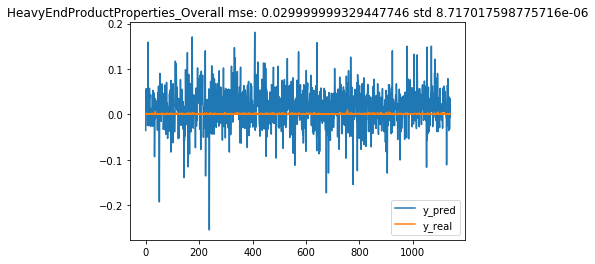

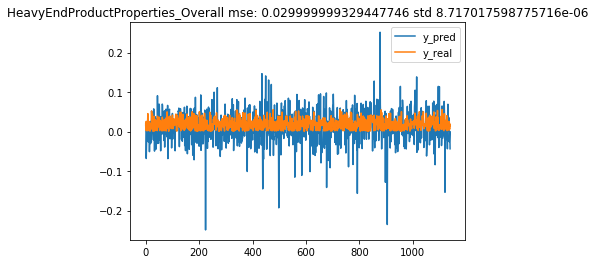

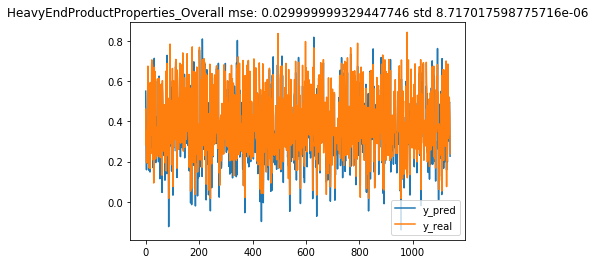

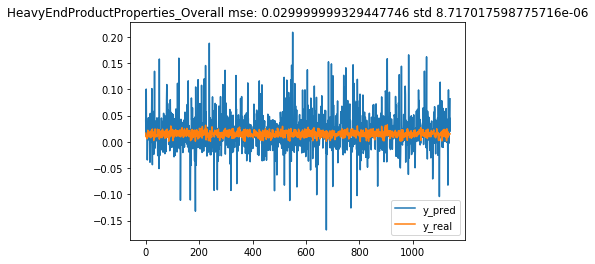

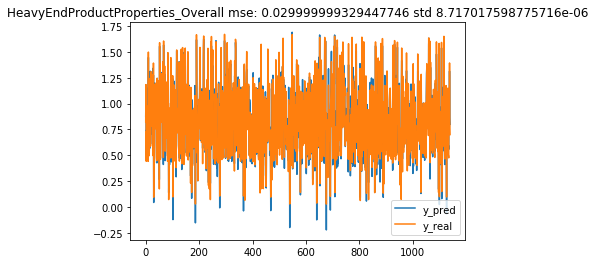

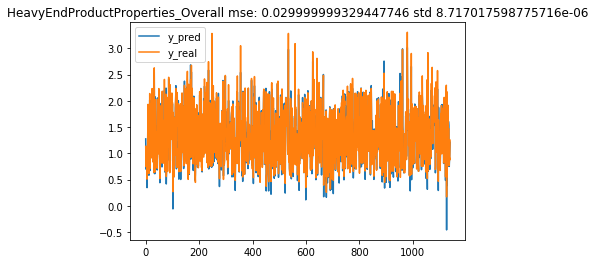

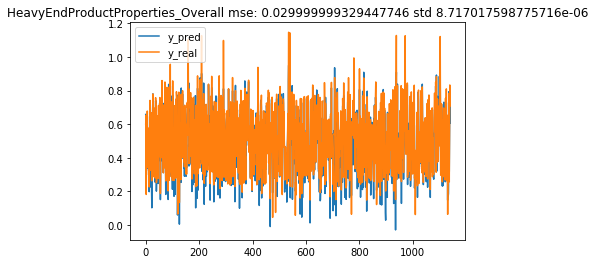

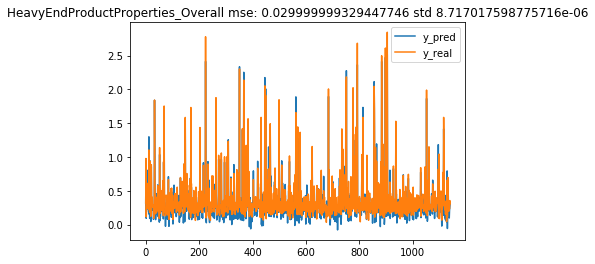

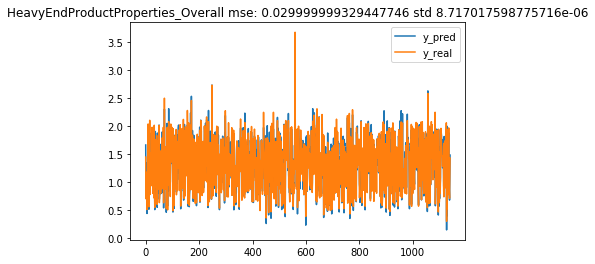

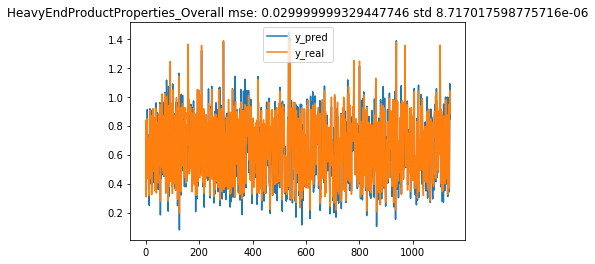

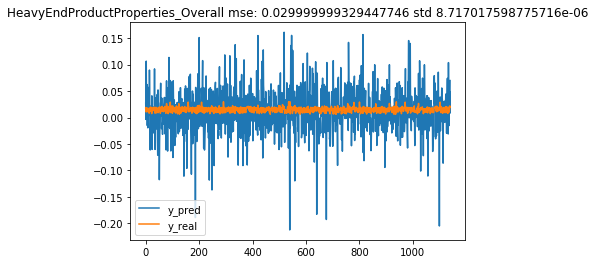

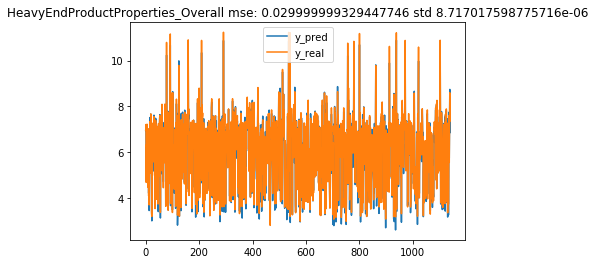

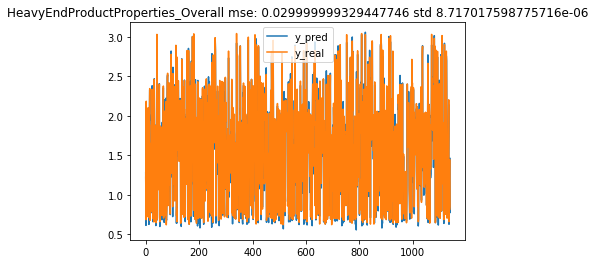

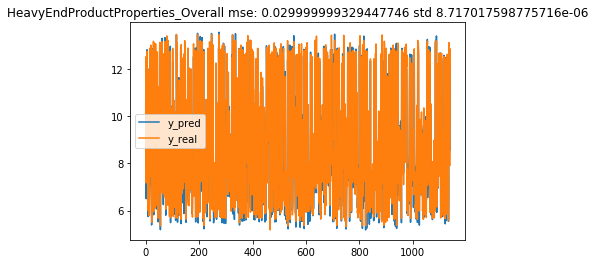

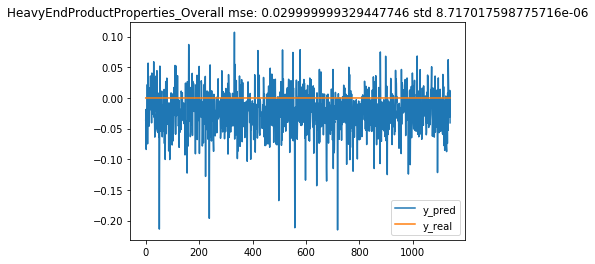

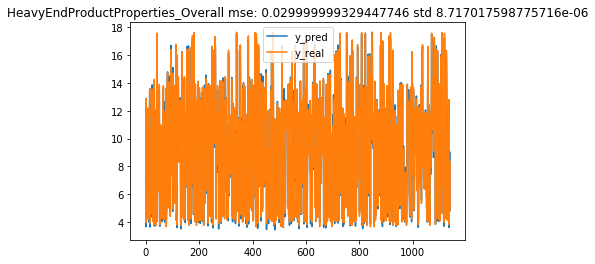

In [19]:
mse_median = t['MSE'].median()
std_min = df.describe().loc['std',:].min()
desc = df.describe()

error_list = []
for i in y_col:
    if desc.loc['std',i] != std_min:
        if t.loc[i,'MSE'] > mse_median:
            error_list.append(i)
print(len(error_list))

for idx,col in enumerate(error_list):
    plt.plot(y_pred[:,idx],label='y_pred')
    plt.plot(y_real[:,idx],label='y_real')
    plt.legend()
    plt.title("{} mse: {} std {}".format(i,
                                         round(t.loc[i,'MSE'],2),
                                         desc.loc['std',i]))
    plt.show()